# Policy Value Estimation - the prediction problem of RL

### Legacy repo does not work with gymnasium so some installs and hacks are needed

In [2]:
#!pip install git+https://github.com/mimoralea/gym-walk#egg=gym-walk

In [1]:
#!pip install gym_walk
#!pip install gymnasium

In [1]:
#import numpy as np
#import gymnasium as gym, gym_walk
#import gymnasium as gym
#from gym_walk.envs import WalkEnv

In [2]:
#from gymnasium.envs.registration import register

In [3]:
#register(
#    # One non-terminal states and two terminal
#    # Technically speaking, this is a bandit MDP
#    id='BanditWalk-v0',
#    entry_point='gym_walk.envs:WalkEnv',
#    # left-most and right-most states are terminal
#    kwargs={'n_states': 1, 'p_stay': 0.0, 'p_backward': 0.0},
#    max_episode_steps=100,
#    reward_threshold=1.0,
#    nondeterministic=True,
#)

In [4]:
#register(
#    # One non-terminal states and two terminal
#    # Technically speaking, this is a bandit MDP
#    id='BanditSlipperyWalk-v0',
#    entry_point='gym_walk.envs:WalkEnv',
#    # left-most and right-most states are terminal
#    kwargs={'n_states': 1, 'p_stay': 0.0, 'p_backward': 0.2},
#    max_episode_steps=100,
#    reward_threshold=1.0,
#    nondeterministic=True,
#)

In [5]:
## (Stochastic) Markov Decission Problem: MDP
## s a (p(a|s), s', r, Teminal?)
#P = {
#    0: {
#        0: [(1.0, 0, 0.0, True)],
#        1: [(1.0, 0, 0.0, True)]
#    },
#    1: {
#        0: [(0.8, 0, 0.0, True), (0.2, 2, 1.0, True)],
#        1: [(0.8, 2, 1.0, True), (0.2, 0, 0.0, True)]
#    },
#    2: {
#        0: [(1.0, 2, 0.0, True)],
#        1: [(1.0, 2, 0.0, True)]
#    }
#}

In [6]:
#env = gym.make('BanditWalk-v0')

# Environment setup

### Upon installing gym_walk lib one can actuall directly instantiated envs used in the book by using proper env parameters

In [1]:
import numpy as np
from gym_walk.envs import WalkEnv

from tqdm import tqdm
import matplotlib.pyplot as plt

from itertools import count

### Slippery walk 1D AKA two-arm stochastic bandid

In [2]:
env = WalkEnv(n_states=5, p_stay=0.0, p_backward=0.0)

In [3]:
env.P

{0: {0: [(1.0, 0, 0.0, True), (0.0, 0, 0.0, True), (0.0, 1, 0.0, False)],
  1: [(1.0, 1, 0.0, False), (0.0, 0, 0.0, True), (0.0, 0, 0.0, True)]},
 1: {0: [(1.0, 0, 0.0, True), (0.0, 1, 0.0, False), (0.0, 2, 0.0, False)],
  1: [(1.0, 2, 0.0, False), (0.0, 1, 0.0, False), (0.0, 0, 0.0, True)]},
 2: {0: [(1.0, 1, 0.0, False), (0.0, 2, 0.0, False), (0.0, 3, 0.0, False)],
  1: [(1.0, 3, 0.0, False), (0.0, 2, 0.0, False), (0.0, 1, 0.0, False)]},
 3: {0: [(1.0, 2, 0.0, False), (0.0, 3, 0.0, False), (0.0, 4, 0.0, False)],
  1: [(1.0, 4, 0.0, False), (0.0, 3, 0.0, False), (0.0, 2, 0.0, False)]},
 4: {0: [(1.0, 3, 0.0, False), (0.0, 4, 0.0, False), (0.0, 5, 0.0, False)],
  1: [(1.0, 5, 0.0, False), (0.0, 4, 0.0, False), (0.0, 3, 0.0, False)]},
 5: {0: [(1.0, 4, 0.0, False), (0.0, 5, 0.0, False), (0.0, 6, 1.0, True)],
  1: [(1.0, 6, 1.0, True), (0.0, 5, 0.0, False), (0.0, 4, 0.0, False)]},
 6: {0: [(1.0, 5, 0.0, False), (0.0, 6, 0.0, True), (0.0, 6, 0.0, True)],
  1: [(1.0, 6, 0.0, True), (0.0, 6

In [4]:
env.reset()

(3, {'prob': 1.0})

In [5]:
env.step(1)

(4, 0.0, False, False, {'prob': 1.0, 'success': False})

## MC policy evaluation

In [6]:
env.action_space

Discrete(2)

In [7]:
env.action_space.n

2

In [8]:
# 10^{-3...0} every 1/10, so we get 10 points of 10 raised to linear space power in the range [-3, 0]
np.logspace(-2, 0, 10, base=10, endpoint=True)

array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ])

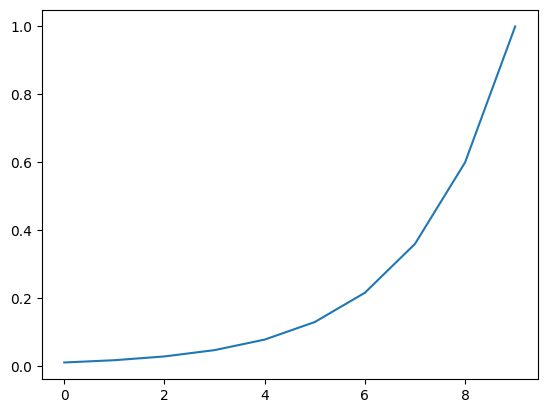

In [9]:
plt.plot(np.logspace(-2, 0, 10, base=10, endpoint=True))

In [10]:
def decay_schedule(init_value,
                   min_value,
                   decay_ratio,
                   max_steps,
                   log_start=-2,
                   log_base=10):
    
    decay_steps = int(decay_ratio * max_steps)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min())/(values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    # padding (0, rem_steps) padds 0 elements on the left and rem_steps elements on the right, with edge value
    values = np.pad(values, (0, rem_steps), 'edge')
    
    return values

In [11]:
# Generate a single experience trajectory passing an episode up to done or max_steps limit
def generate_trajectory(pi, env, max_steps=20):
    done, trajectory = False, []
    while not done:
        state = env.reset()[0] # There was no [0] in the Grokking RL book
        for t in count():
            action = pi(state)
            # Typical step return value for walk-5:
            # (5, 0.0, False, False, {'prob': 0.5, 'success': False})
            next_state, reward, done, _ , _= env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state

    return np.array(trajectory, 'object')

In [38]:
def mc_prediction(pi,
                  env,
                  gamma=1.0,
                  init_alpha=0.5,
                  min_alpha=0.01,
                  alpha_decay_ratio=0.3,
                  n_episodes=500,
                  max_steps=100,
                  first_visit=True):
    nS = env.observation_space.n
    discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False)
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)

    V = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))

    for e in tqdm(range(n_episodes), leave=False):
        trajectory = generate_trajectory(pi, env, max_steps)
        visited = np.zeros(nS, dtype='bool')
        # Original line in the book has the unused reward element
        #for t, (state, _, reward, _, _) in enumerate(trajectory):
        for t, (state, _, _, _, _) in enumerate(trajectory):
            if visited[state] and first_visit:
                continue
            visited[state] = True
            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            V[state] = V[state] + alphas[e] * (G - V[state])
            V_track[e] = V
    return V.copy(), V_track
        

In [31]:
env.action_space.n

2

In [32]:
np.random.choice(range(env.action_space.n), env.observation_space.n)

array([0, 1, 1, 0, 1, 1, 0])

In [40]:
# Random policy pi
pi = lambda s: np.random.choice(range(env.action_space.n), env.observation_space.n)[s]

In [41]:
# Optimal policy
# pi = lambda s: [1, 1, 1, 1, 1, 1, 1][s]

In [42]:
v_s, v_t = mc_prediction(pi, env)

In [45]:
v_t.shape

(500, 7)

In [44]:
v_s

array([0.        , 0.12007749, 0.27999409, 0.46817353, 0.62755596,
       0.78754516, 0.        ])

## TD Learning - less variance and more sample efficient estimation

In [47]:
type(env)

gym_walk.envs.walk_env.WalkEnv

In [52]:
def td(pi,
       env:WalkEnv, # Hinting gives member unroll
       gamma=1.0,
       init_alpha=0.5,
       min_alpha=0.01,
       alpha_decay_ratio=0.3,
       n_episodes=500):
    
    nS = env.observation_space.n
    V = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)

    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset()[0], False # No [0] in the Grokking book
        while not done:
            action = pi(state)
            next_state, reward, done, _, _ = env.step(action)
            td_target = reward + gamma * V[next_state] * (not done)
            td_error = td_target - V[state]
            V[state] += alphas[e] * td_error
            state = next_state
        V_track[e] = V

    return V, V_track
    

In [53]:
v_s, v_t = td(pi, env)

### The result is quite close to the above MC estimation

In [54]:
v_s

array([0.        , 0.16360175, 0.32686215, 0.48263408, 0.64678733,
       0.82021294, 0.        ])